In [0]:
#모듈 import
import numpy as np

import os
import shutil

In [2]:
#데이터 내려받기
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   242M      0  0:00:03  0:00:03 --:--:--  242M
 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [3]:
#폴더 이동과 하위 폴더 이름 가져오기

os.chdir('PetImages')
!ls

Cat  Dog


In [4]:
#파일 확인해보기.
print(os.listdir('Cat')[:5])
print(os.listdir('Dog')[:5])

['8811.jpg', '7952.jpg', '7808.jpg', '10598.jpg', '10096.jpg']
['8811.jpg', '7952.jpg', '7808.jpg', '10598.jpg', '10096.jpg']


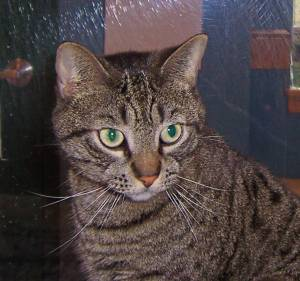

In [10]:
#이미지 꺼내보기
from IPython.display import Image
Image(filename='Cat/1.jpg')

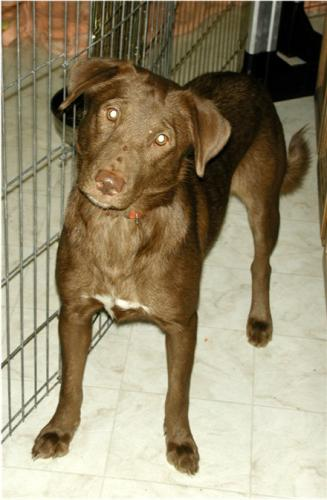

In [11]:
Image(filename='Dog/1.jpg')

## 데이터 분할

In [0]:
# validation 데이터 폴더 생성
os.mkdir('val_Dog')
os.mkdir('val_Cat')

# test 데이터 폴더 생성
os.mkdir('test_Dog')
os.mkdir('test_Cat')

In [13]:
#데이터 분할
#test
files_cat = os.listdir('Cat') # Cat 폴더의 파일 목록을 가져옴.
files_dog = os.listdir('Dog') # Dog 폴더의 파일 목록을 가져옴.

files_cat_jpg = [file for file in files_cat if file.endswith( '.jpg')] #파일 중 .jpg로 끝나는 파일 목록만 가져온다.
files_dog_jpg = [file for file in files_dog if file.endswith( '.jpg')] #파일 중 .jpg로 끝나는 파일 목록만 가져온다.

#데이터 샘플 보기
print('Cat: ', files_cat_jpg[:10])
print('Dog: ', files_dog_jpg[:10])

Cat:  ['8811.jpg', '7952.jpg', '7808.jpg', '10598.jpg', '10096.jpg', '8497.jpg', '11431.jpg', '7889.jpg', '9690.jpg', '11054.jpg']
Dog:  ['8811.jpg', '7952.jpg', '7808.jpg', '10598.jpg', '10096.jpg', '8497.jpg', '11431.jpg', '7889.jpg', '9690.jpg', '11054.jpg']


In [14]:

#데이터 길이 구함.
len_cat = len(files_cat_jpg)
len_dog = len(files_dog_jpg)

print('Cat: ', len_cat)
print('Dog: ', len_dog)

Cat:  12500
Dog:  12500


In [0]:
#test 파일 분할

data_len = 12500
data_ratio = 0.2
test_len = int(data_len*data_ratio)

np.random.seed(611)
test_idx = np.random.choice(data_len, test_len, replace=False)

for i in test_idx:
  shutil.move('Dog/'+str(i)+'.jpg', 'test_Dog/'+str(i)+'.jpg')
  shutil.move('Cat/'+str(i)+'.jpg', 'test_Cat/'+str(i)+'.jpg')
  

In [0]:
#validation 파일 분할

# data_len = len(os.listdir('Cat'))
# val_len = int(data_len * data_ratio)
# val_idx = np.random.choice(data_len, val_len, replace=False)

# for i in val_idx:
#   shutil.move('Dog/'+str(i)+'.jpg', 'val_Cat')


In [16]:
#모델 만들기
input_shape = (150, 150, 3)

from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=0.0001), metrics=['acc'])

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

## 데이터 전처리
데이터가 모델에 들어가기 위해선 텐서형태로 변환해야한다. 이미지 파일은 픽셀값으로 디코딩한다.

In [0]:
keras.preprocessing.image import ImageDataGenerator

train_data = ImageDataGenerator(rescale=1./255)
test_data = ImageDataGenerator(rescale=1./255)

preprocessed_data = train_data.flow_from_directory(
    
)